# Day 03

## Setup


In [1]:
import grama as gr
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 6] # Need square aspect ratio for gradients to appear normal
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## Base model


In [2]:
md_point = (
    gr.Model("Minimum-energy point")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            x=(df.k1*df.x1 + df.k2*df.x2 + df.k3*df.x3) / (df.k1+df.k2+df.k3),
            y=(df.k1*df.y1 + df.k2*df.y2 + df.k3*df.y3) / (df.k1+df.k2+df.k3),
        ),
        var=["x1", "x2", "x3", "y1", "y2", "y3", "k1", "k2", "k3"],
        out=["x", "y"],
    )
    >> gr.cp_marginals(
        k1=dict(dist="uniform", loc=0.25, scale=0.5),
        k2=dict(dist="uniform", loc=0.25, scale=0.5),
        k3=dict(dist="uniform", loc=0.25, scale=0.5),
    )
    >> gr.cp_copula_independence()
)
# Test evaluation
md_point >> gr.ev_df(df=gr.df_make(x1=-1, x2=+1, x3=0, y1=1, y2=1, y3=0, k1=1, k2=1, k3=1))
# Show metadata
md_point

model: Minimum-energy point

  inputs:
    var_det:
      x2: (unbounded)
      x1: (unbounded)
      y2: (unbounded)
      y1: (unbounded)
      y3: (unbounded)
      x3: (unbounded)

    var_rand:
      k1: (+0) uniform, {'mean': '5.000e-01', 's.d.': '1.400e-01', 'COV': 0.29, 'skew.': 0.0, 'kurt.': 1.8}
      k2: (+0) uniform, {'mean': '5.000e-01', 's.d.': '1.400e-01', 'COV': 0.29, 'skew.': 0.0, 'kurt.': 1.8}
      k3: (+0) uniform, {'mean': '5.000e-01', 's.d.': '1.400e-01', 'COV': 0.29, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      f0: ['x1', 'x2', 'x3', 'y1', 'y2', 'y3', 'k1', 'k2', 'k3'] -> ['x', 'y']

## Try 1: Minimize mean distance from goal


In [3]:
md_objective1 = (
    gr.Model("Monte Carlo Analysis of Model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.eval_sample(
            md_point,
            df_det=df >> gr.tf_mutate(id=DF.index),
            n=50,
            seed=101,
        )
        >> gr.tf_mutate(d=gr.sqrt((DF.x-0)**2 + (DF.y-0)**2))
        >> gr.tf_group_by(DF.id)
        >> gr.tf_summarize(
            d_mean=gr.mean(DF.d),
            d_sd=gr.sd(DF.d),
        ),
        var=["x1", "x2", "x3", "y1", "y2", "y3"],
        out=["d_mean", "d_sd"],
    )
    >> gr.cp_bounds(
        ## No constraints
        x1=(-np.Inf, +np.Inf), y1=(-np.Inf, +np.Inf),
        x2=(-np.Inf, +np.Inf), y2=(-np.Inf, +np.Inf),
        x3=(-np.Inf, +np.Inf), y3=(-np.Inf, +np.Inf),
    )
)
# Test evaluation
md_objective1 >> gr.ev_df(df=gr.df_make(x1=-1, x2=+1, x3=0, y1=1, y2=1, y3=0))
# Show metadata
md_objective1

model: Monte Carlo Analysis of Model

  inputs:
    var_det:
      x2: [-inf, inf]
      y2: [-inf, inf]
      x1: [-inf, inf]
      y1: [-inf, inf]
      y3: [-inf, inf]
      x3: [-inf, inf]

    var_rand:

    copula:
      None

  functions:
      f0: ['x1', 'x2', 'x3', 'y1', 'y2', 'y3'] -> ['d_mean', 'd_sd']

### Run optimizer


In [4]:
# Start with a proposal for the tower locations
df_guess = gr.df_make(x1=-1, x2=+1, x3=0, y1=+0.5, y2=+0.5, y3=-0.5)

# Optimize locations to minimize variation in location
df_optimized1 = (
    md_objective1
    >> gr.ev_min(
        out_min="d_mean",
        df_start=df_guess
    )
)
df_optimized1

Estimated runtime: 0.0000 sec


,x2,x1,y2,y1,y3,x3,x2_0,x1_0,y2_0,y1_0,y3_0,x3_0,d_mean,d_sd,success,message,n_iter
0,-9.625698e-07,-0.000004,0.000017,-0.000007,-0.000009,0.000004,1.0,-1.0,0.5,0.5,-0.5,0.0,0.000002,0.000001,True,Optimization terminated successfully,33


### Visualize

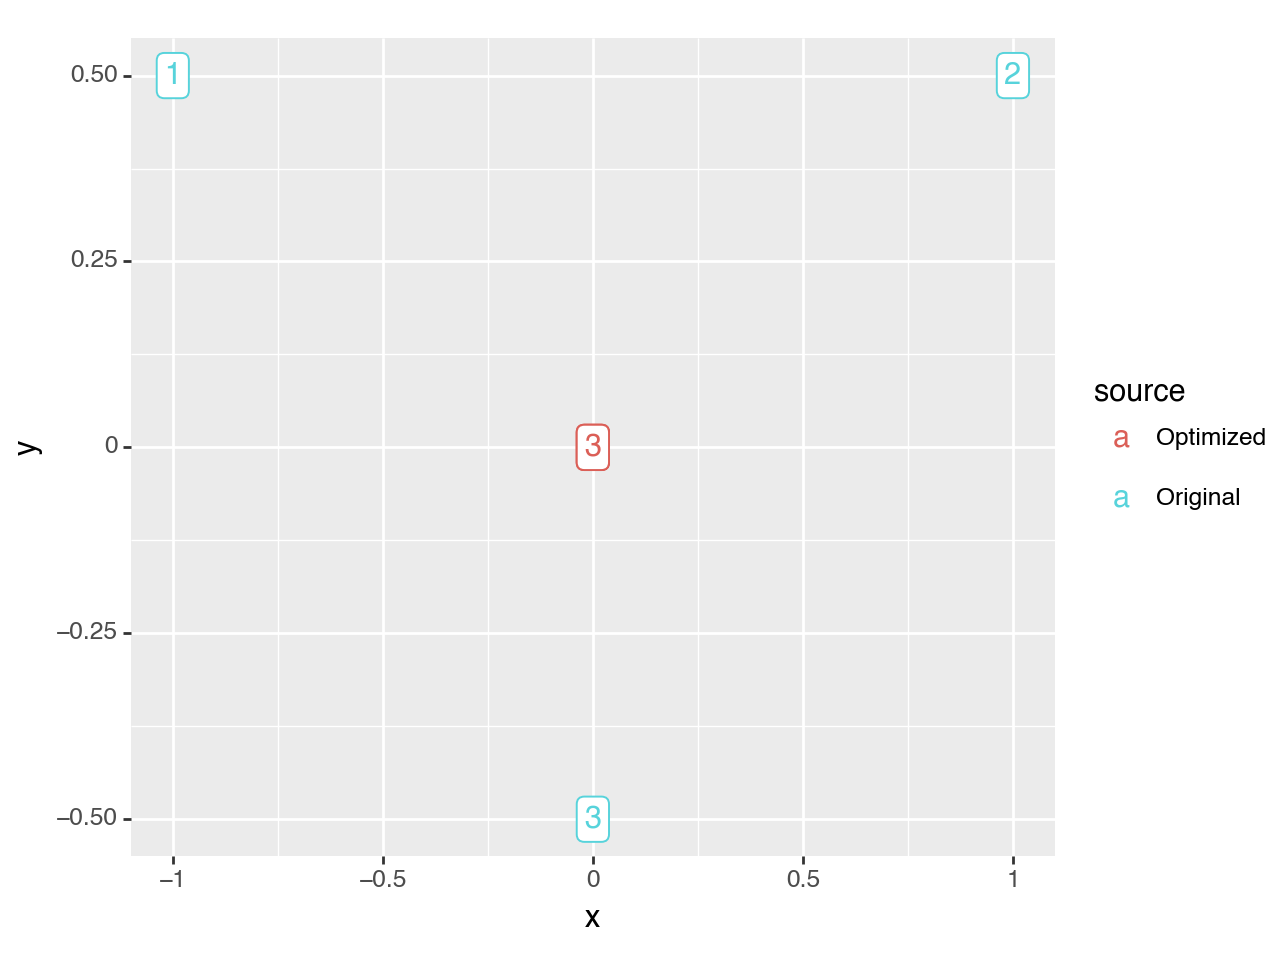

<Figure Size: (640 x 480)>

In [5]:
(
    df_guess >> gr.tf_mutate(source="Original")
    >> gr.tf_bind_rows(
        df_optimized1
        >> gr.tf_select(DF.x1, DF.x2, DF.x3, DF.y1, DF.y2, DF.y3)
        >> gr.tf_mutate(source="Optimized")
    )
    >> gr.tf_pivot_longer(
        columns=["x1", "x2", "x3", "y1", "y2", "y3"],
        names_pattern="(x|y)(\\d)",
        names_to=[".value", "tower"]
    )

    >> gr.ggplot(gr.aes("x", "y", color="source"))
    + gr.geom_label(
        mapping=gr.aes(label="tower")
    )
)

## Try 2: Constrain tower locations

In [6]:
md_objective2 = (
    gr.Model("Monte Carlo Analysis of Model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.eval_sample(
            md_point,
            df_det=df >> gr.tf_mutate(id=DF.index),
            n=50,
            seed=101,
        )
        >> gr.tf_mutate(d=gr.sqrt((DF.x-0)**2 + (DF.y-0)**2))
        >> gr.tf_group_by(DF.id)
        >> gr.tf_summarize(
            d_mean=gr.mean(DF.d),
            d_sd=gr.sd(DF.d),
        ),
        var=["x1", "x2", "x3", "y1", "y2", "y3"],
        out=["d_mean", "d_sd"],
    )
    >> gr.cp_bounds(
        # "Box constraints" on tower positions
        x1=(-np.Inf, -0.5), y1=(+0.5, +np.Inf), # Top left
        x2=(+0.5, +np.Inf), y2=(+0.5, +np.Inf), # Top right
        x3=(-10, +10), y3=(-np.Inf, -0.5), # Bottom
    )
)
# Test evaluation
md_objective2 >> gr.ev_df(df=gr.df_make(x1=-1, x2=+1, x3=0, y1=1, y2=1, y3=0))
# Show metadata
md_objective2

model: Monte Carlo Analysis of Model

  inputs:
    var_det:
      x2: [0.5, inf]
      y2: [0.5, inf]
      x1: [-inf, -0.5]
      y1: [0.5, inf]
      y3: [-inf, -0.5]
      x3: [-10, 10]

    var_rand:

    copula:
      None

  functions:
      f0: ['x1', 'x2', 'x3', 'y1', 'y2', 'y3'] -> ['d_mean', 'd_sd']

### Run optimizer


In [7]:
# Start with a proposal for the tower locations
df_guess = gr.df_make(x1=-1, x2=+1, x3=0, y1=+0.5, y2=+0.5, y3=-0.5)

# Optimize locations to minimize variation in location
df_optimized2 = (
    md_objective2
    >> gr.ev_min(
        out_min="d_mean",
        df_start=df_guess
    )
)
df_optimized2

Estimated runtime: 0.0000 sec


,x2,x1,y2,y1,y3,x3,x2_0,x1_0,y2_0,y1_0,y3_0,x3_0,d_mean,d_sd,success,message,n_iter
0,0.5,-0.5,0.5,0.5,-0.913842,0.019283,1.0,-1.0,0.5,0.5,-0.5,0.0,0.121628,0.059007,True,Optimization terminated successfully,7


### Visualize

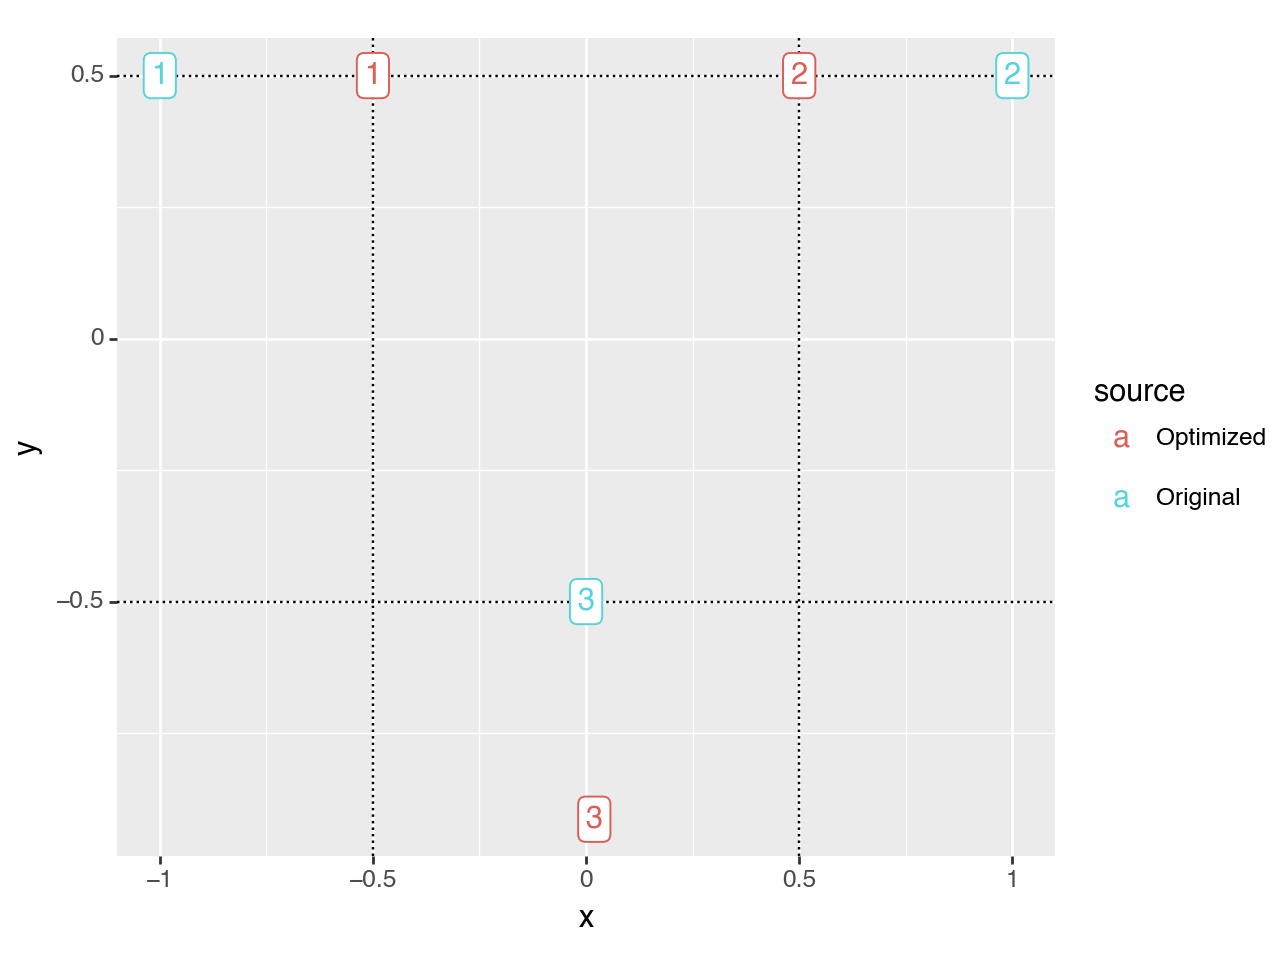

<Figure Size: (640 x 480)>

In [8]:
(
    df_guess >> gr.tf_mutate(source="Original")
    >> gr.tf_bind_rows(
        df_optimized2
        >> gr.tf_select(DF.x1, DF.x2, DF.x3, DF.y1, DF.y2, DF.y3)
        >> gr.tf_mutate(source="Optimized")
    )
    >> gr.tf_pivot_longer(
        columns=["x1", "x2", "x3", "y1", "y2", "y3"],
        names_pattern="(x|y)(\\d)",
        names_to=[".value", "tower"]
    )

    >> gr.ggplot(gr.aes("x", "y", color="source"))
    + gr.geom_hline(
        linetype="dotted",
        yintercept=[-0.5, +0.5],
    )
    + gr.geom_vline(
        linetype="dotted",
        xintercept=[-0.5, +0.5],
    )
    + gr.geom_label(mapping=gr.aes(label="tower"))
)